In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import random
import math

%matplotlib inline

## One Region Monte Carlo Simulation (Central - High)

In [2]:
# Initial population of Central Region
Central = 511660
S_init = 234144
E_init = 1
I_init = 1
A_init = 1
R_init = 0

# Simulation period
t = 1000 # days in 2 months

In [3]:
param_dict = {
    'High': [0.4e-6, 0.2e-6, 1/5, 0.4, 1/14, 0.001],
    'Low': [0.4e-6, 0.2e-6, 1/5, 0.4, 1/14, 0.001],
}

beta_symp = param_dict['High'][0]
beta_asym = param_dict['High'][1]
gamma = param_dict['High'][2]
theta = param_dict['High'][3]
lamb = param_dict['High'][4]
delta = param_dict['High'][5]

In [4]:
# fig, ax = plt.subplots(1, 1, figsize=(10, 6))
# for i in range(0, 20):
#     mean, var, skew, kurt = stats.binom.stats(S_init, 0.8, moments='mvsk') # mcsk = mean, variance, skew, kurtosis
#     ax.plot(mean)

In [5]:
df = pd.DataFrame(columns=['Day', 'S', 'E', 'I', 'A', 'R'])
# add initial values to the dataframe
df.loc[0] = [1, S_init, E_init, I_init, A_init, R_init]

In [7]:
for day in range(t+1):

    my_generator = np.random.default_rng()
    # Calculate new values
    # S_new = S_init - ((beta_symp * I_init + beta_asym * A_init) * S_init)
    # E_new = E_init + ((beta_symp * I_init + beta_asym * A_init) * S_init) - (gamma * theta * E_init) - (gamma * (1 - theta) * E_init)
    # I_new = I_init + (gamma * theta * E_init) - ((delta + lamb) * I_init)
    # A_new = A_init + (gamma * (1 - theta) * E_init) - (delta * A_init)
    # R_new = R_init + (((delta + lamb) * I_init) + (delta * A_init))
    S_to_E = my_generator.binomial(S_init, (beta_symp * I_init) + (beta_asym * A_init))
    E_to_I = my_generator.binomial(E_init, gamma*theta)
    E_to_A = my_generator.binomial(E_init, gamma*(1-theta))
    I_to_R = my_generator.binomial(I_init, delta + lamb)
    A_to_R = my_generator.binomial(A_init, delta)

    S_new = max(S_init - S_to_E, 0)
    E_new = max(E_init + S_to_E - E_to_I - E_to_A, 0)
    I_new = max(I_init + E_to_I - I_to_R, 0)
    A_new = max(A_init + E_to_A - A_to_R, 0)
    R_new = max(R_init + I_to_R + A_to_R, 0)

    # Store each day's values in a dataframe
    df.loc[day + 1] = [int(day + 2), math.ceil(S_new), math.ceil(E_new), math.ceil(I_new), math.ceil(A_new), math.ceil(R_new)]

    # Update values
    S_init, E_init, I_init, A_init, R_init = math.ceil(S_new), math.ceil(E_new), math.ceil(I_new), math.ceil(A_new), math.ceil(R_new)

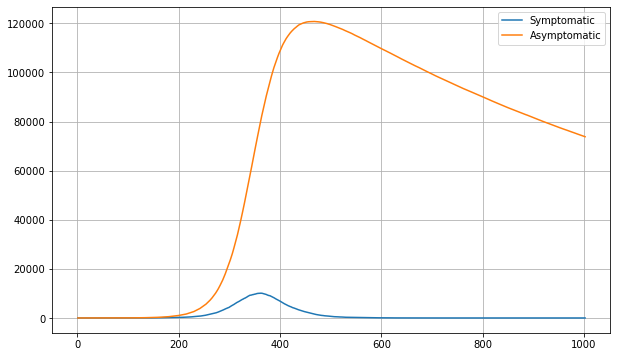

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))
# ax.plot(df['Day'], df['S'], label='Susceptible')
# ax.plot(df['Day'], df['E'], label='Exposed')
ax.plot(df['Day'], df['I'], label='Symptomatic')
ax.plot(df['Day'], df['A'], label='Asymptomatic')
# ax.plot(df['Day'], df['R'], label='Recovered')
ax.legend()
ax.grid()